In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Налаштування візуалізацій
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

In [2]:
# Завантажуємо тренувальний та тестовий набори
train_df = pd.read_csv('../data/train_standard_scaled.csv', index_col='DateTime', parse_dates=True)
test_df = pd.read_csv('../data/test_standard_scaled.csv', index_col='DateTime', parse_dates=True)

print("Масштабовані дані завантажено.")
print(f"Розмір тренувального набору: {train_df.shape}")
print(f"Розмір тестового набору: {test_df.shape}")

# Визначаємо цільову змінну та ознаки
TARGET_COLUMN = 'Global_active_power'
FEATURES = [col for col in train_df.columns if col != TARGET_COLUMN]

X_train = train_df[FEATURES]
y_train = train_df[TARGET_COLUMN]

X_test = test_df[FEATURES]
y_test = test_df[TARGET_COLUMN]

Масштабовані дані завантажено.
Розмір тренувального набору: (27648, 8)
Розмір тестового набору: (6912, 8)


In [3]:
def create_sequences(X, y, time_steps=24):
    """
    Створює послідовності для LSTM/GRU моделей.
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24 # Використовуємо дані за останні 24 години для прогнозу

X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, TIME_STEPS)

print(f"Форма тренувальних послідовностей (X): {X_train_seq.shape}")
print(f"Форма тестових послідовностей (X): {X_test_seq.shape}")

Форма тренувальних послідовностей (X): (27624, 24, 7)
Форма тестових послідовностей (X): (6888, 24, 7)


In [11]:
# --- ФІНАЛЬНА, НАЙБІЛЬШ СТАБІЛЬНА ВЕРСІЯ ---
from tensorflow.keras.optimizers import Adam

# Побудова моделі (архітектуру залишаємо стабільною, як у попередньому кроці)
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, activation='tanh'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

# --- ЗМІНИ ТУТ ---
# 1. Створюємо оптимізатор Adam з меншою швидкістю навчання
# 2. Додаємо обрізання градієнтів (clipnorm=1.0)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Компіляція моделі з новим оптимізатором
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

print("Фінальна архітектура LSTM моделі:")
lstm_model.summary()

# Рання зупинка
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nПочинаємо навчання моделі LSTM...")
history = lstm_model.fit(X_train_seq, y_train_seq,
                         epochs=50,
                         batch_size=32,
                         validation_split=0.1,
                         callbacks=[early_stopping],
                         verbose=1)

print("Навчання завершено.")

Фінальна архітектура LSTM моделі:


/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 24, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,851 (124.42 KB)

 Trainable params: 31,851 (124.42 KB)

 Non-trainable params: 0 (0.00 B)


Починаємо навчання моделі LSTM...
Epoch 1/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: nan - val_loss: nan
Epoch 2/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: nan - val_loss: nan
Epoch 3/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: nan - val_loss: nan
Epoch 4/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: nan - val_loss: nan
Epoch 5/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: nan - val_loss: nan
Epoch 6/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: nan - val_loss: nan
Навчання завершено.


216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
--- ДІАГНОСТИКА ---
Кількість NaN одразу після прогнозу: 6888
Кількість нескінченних значень (inf): 0
Кількість NaN після очищення: 0
--------------------
NaNs у фінальних фактичних значеннях: 0
NaNs у фінальних прогнозах: 0

LSTM Mean Absolute Error (MAE): 20.21
LSTM Root Mean Squared Error (RMSE): 32.35


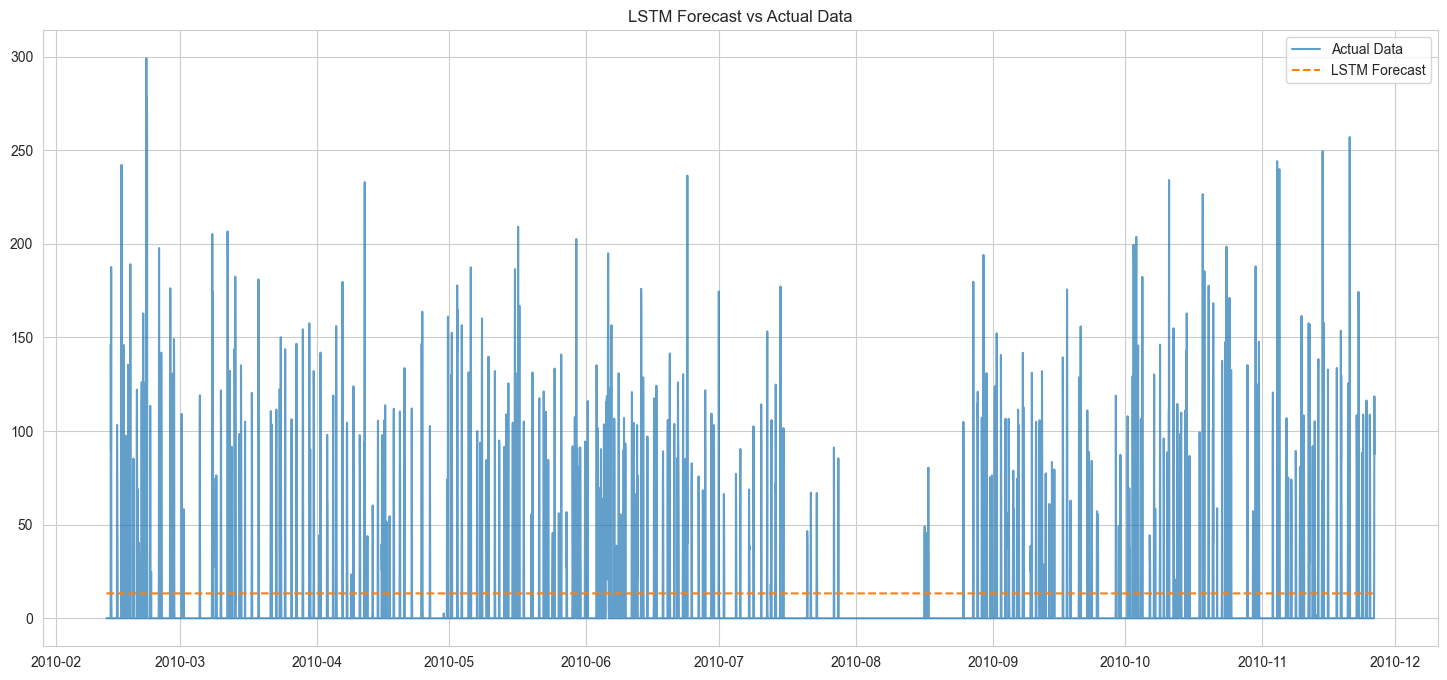

In [12]:
# --- ФІНАЛЬНА ВЕРСІЯ З ДОДАТКОВОЮ ДІАГНОСТИКОЮ ---

# Робимо прогноз на тестових даних
predictions_lstm_scaled = lstm_model.predict(X_test_seq)


# --- ДІАГНОСТИЧНИЙ КРОК 1: Перевіряємо вихід моделі ---
print("--- ДІАГНОСТИКА ---")
print(f"Кількість NaN одразу після прогнозу: {np.isnan(predictions_lstm_scaled).sum()}")
print(f"Кількість нескінченних значень (inf): {np.isinf(predictions_lstm_scaled).sum()}")

# ЗАХИСНИЙ МЕХАНІЗМ: Замінюємо будь-які NaN/inf на 0, щоб уникнути помилок далі
predictions_lstm_scaled = np.nan_to_num(predictions_lstm_scaled)
print(f"Кількість NaN після очищення: {np.isnan(predictions_lstm_scaled).sum()}")
print("--------------------")


# Завантажуємо скейлер, який ми зберегли раніше
scaler = joblib.load('../models/standard_scaler.pkl')

# Готуємо датафрейм для зворотного перетворення
test_df_for_inverse = test_df.iloc[TIME_STEPS:].copy()
target_col_index = test_df.columns.get_loc(TARGET_COLUMN)


# 2. Для прогнозів: вставляємо очищені прогнози в стовпець
test_df_for_inverse[TARGET_COLUMN] = predictions_lstm_scaled.ravel()
# Виконуємо зворотне перетворення
predictions_lstm = scaler.inverse_transform(test_df_for_inverse)[:, target_col_index]

# 3. Для фактичних значень: вставляємо реальні значення
test_df_for_inverse[TARGET_COLUMN] = y_test_seq.ravel()
# Виконуємо зворотне перетворення
y_test_inversed = scaler.inverse_transform(test_df_for_inverse)[:, target_col_index]


# --- Оцінка та Візуалізація ---

# Перевіряємо на NaN ще раз перед розрахунком метрик
print(f"NaNs у фінальних фактичних значеннях: {np.isnan(y_test_inversed).sum()}")
print(f"NaNs у фінальних прогнозах: {np.isnan(predictions_lstm).sum()}")

# Розрахунок метрик
mae_lstm = mean_absolute_error(y_test_inversed, predictions_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inversed, predictions_lstm))

print(f"\nLSTM Mean Absolute Error (MAE): {mae_lstm:.2f}")
print(f"LSTM Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")

# Візуалізація результатів
plt.plot(test_df.index[TIME_STEPS:], y_test_inversed, label='Actual Data', alpha=0.7)
plt.plot(test_df.index[TIME_STEPS:], predictions_lstm, label='LSTM Forecast', linestyle='--')
plt.title('LSTM Forecast vs Actual Data')
plt.legend()
plt.show()

In [13]:
lstm_model.save('../models/lstm_model.keras')
print("Модель LSTM успішно збережена.")

Модель LSTM успішно збережена.
